In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np

from fitter import Fitter
from scipy.stats import exponnorm, erlang, gennorm

from skmultiflow.drift_detection import PageHinkley
from driftwatch import GreedyKS, IksReservoir, ReservoirSampling, LallDDSketch

In [7]:
def get_methods(ref_distrib, num_bins, min_instances):
    ph = PageHinkley(min_instances=min_instances)
    gks = GreedyKS(dist=ref_distrib, m=num_bins, min_instances=min_instances)#, drift_threshold=0.000001)
    rs = ReservoirSampling(num_bins, ref_distrib)


    methods = {
        "page hinkley" : ph,
        "greedyKS" : gks,
        "reservoir sampling" : rs,
        
    }
    methods_drifts = {
    "page hinkley" : [],
    "greedyKS" : [],
    "reservoir sampling" : [],

    }

    methods_times = {
        "page hinkley" : 0,
        "greedyKS" : 0,
        "reservoir sampling" : 0,

    }

    methods_colors = {
        "page hinkley" : 'r',
        "greedyKS" : 'g',
        "reservoir sampling" : 'b',

    }

    return methods, methods_drifts, methods_times, methods_colors

In [23]:
def load_data(column):
    stream = []
    days = range(1, 23) # 1, 32
    months = range(1, 2) #1, 3
    for month in months:
        month_2_digits = '{month:02}'.format(month=month)
        path = './COVID19_Tweets_Dataset_2020/Summary_Sentiment/2020_' + month_2_digits + '/'

        for day in days:
            if month == 2 and day > 29:
                continue
            if month == 1 and day < 22:
                continue

            for hour in range(24):
                file_name = path + f'2020_{month_2_digits}_' + '{day:02}'.format(day=day) + '_{hour:02}'.format(hour=hour) + '_Summary_Sentiment.csv'
                stream.append(pd.read_csv(file_name)[column])

    return pd.concat(stream, ignore_index=True), stream


stream_ln = load_data('Logits_Negative')[0]
stream_lp = load_data('Logits_Positive')[0]
stream_lt, tweets_per_file = load_data('Logits_Neutral')

In [83]:
def get_fitted_ks_values(data):
    f = Fitter(data, distributions=['exponnorm', 'fatiguelife', 'moyal', 'alpha', 'erlang', 'norm', 'expon'])
    f.fit()
    return f.summary(plot=False, clf=False)['ks_pvalue'].values

In [82]:
ks_values = []
for tweets_hour in tweets_per_file:
    ks_values.append(get_fitted_ks_values(tweets_hour))
    break

np.mean([i>=.01 for i in np.concatenate(ks_values)])

Fitting 7 distributions: 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


1.0

Fitting 110 distributions:   1%|          | 1/110 [00:00<00:16,  6.52it/s]SKIPPED genpareto distribution (taking more than 30 seconds)
SKIPPED gompertz distribution (taking more than 30 seconds)
SKIPPED halfgennorm distribution (taking more than 30 seconds)
Fitting 110 distributions:   7%|▋         | 8/110 [00:30<05:10,  3.04s/it]SKIPPED betaprime distribution (taking more than 30 seconds)
SKIPPED burr distribution (taking more than 30 seconds)
Fitting 110 distributions:  25%|██▌       | 28/110 [01:17<09:29,  6.94s/it]SKIPPED gausshyper distribution (taking more than 30 seconds)
SKIPPED genexpon distribution (taking more than 30 seconds)
Fitting 110 distributions:  73%|███████▎  | 80/110 [03:14<00:55,  1.84s/it]SKIPPED ncx2 distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
Fitting 110 distributions:  74%|███████▎  | 81/110 [03:14<00:42,  1.48s/it]SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED norminvgaus

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gennorm,0.561519,597.836729,-402450.655683,inf,0.025493,6.033894e-21
exponweib,0.562898,605.857331,-402350.980210,inf,0.027563,2.055205e-24
beta,0.563204,618.355525,-402331.254358,inf,0.022971,4.373689e-17
weibull_min,0.571336,576.598393,-401820.924814,inf,0.027168,9.903171e-24
exponpow,0.571995,663.657968,-401779.022993,inf,0.036536,1.418609e-42


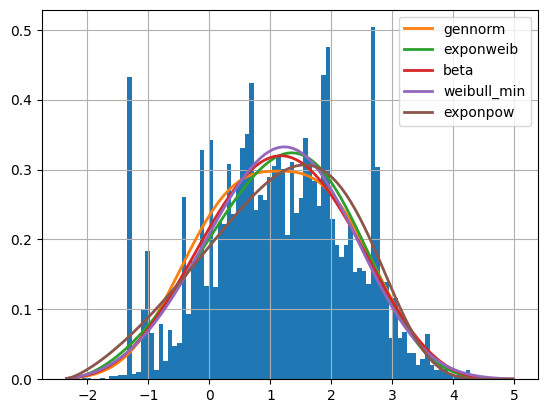

In [9]:
f_neg = Fitter(stream_ln)#, distributions=['exponnorm', 'fatiguelife', 'moyal', 'alpha', 'erlang', 'norm', 'expon'])
f_neg.fit()
f_neg.summary()

In [10]:
# f_pos = Fitter(stream_lp)
# f_pos.fit()
# f_pos.summary()

In [18]:
# f_neu = Fitter(stream_lt)
# f_neu.fit()
# f_neu.summary()
# f.get_best()


In [19]:
# distribution = exponnorm(5.025553216466441, loc=-1.1327249541070226, scale=0.2032867510140243)
distribution = gennorm(*f_neg.fitted_param['gennorm'])

methods, methods_drifts, methods_times, methods_colors = get_methods(distribution, num_bins=10**3, min_instances=0) 
         
for m in methods:
    start = time.time()
    for i, x in enumerate(stream_ln):
        methods[m].add_element(x)
        if methods[m].detected_change():
            methods_drifts[m].append(i)
            methods[m].reset()
    methods_times[m] = methods_times[m] + time.time() - start

print('Number of tweets processed: ', len(stream_ln))

KeyboardInterrupt: 

In [ ]:
methods_times

{'page hinkley': 0.25894808769226074,
 'greedyKS': 64.47171211242676,
 'reservoir sampling': 519.1544232368469}

In [11]:
print('Reservoir S ', len(methods_drifts['reservoir sampling']))
print('GreedyKS ', len(methods_drifts['greedyKS']))
print('Page hinkley ', len(methods_drifts['page hinkley']))


Reservoir S  9793
GreedyKS  9769
Page hinkley  14


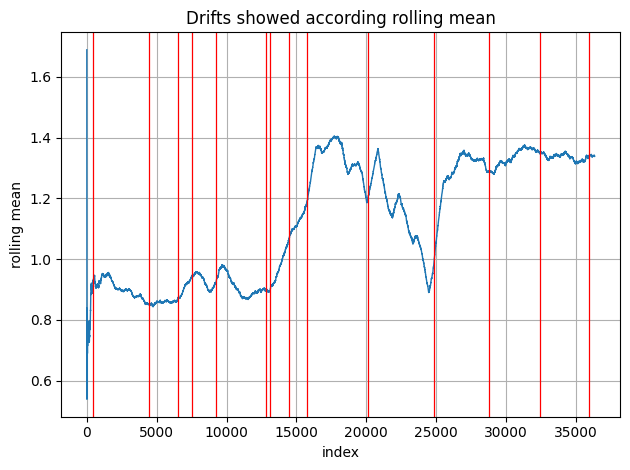

In [13]:
rolling_mean = stream_ln.rolling(len(stream_ln)//10, min_periods=0).mean()

# plt.figure(figsize=(5,3.5))
plt.plot(rolling_mean, linewidth=1)

for m in methods_drifts:
    if m != 'page hinkley':
        continue
    for d in methods_drifts[m]:
        plt.axvline(x = d, color = methods_colors[m], linewidth=0.9, label=m)




plt.title('Drifts showed according rolling mean')
# plt.legend()
plt.xlabel('index')
plt.ylabel('rolling mean')
plt.grid(True)
plt.tight_layout()
plt.show()